# Tarea KMeans & Shap

Diego Lozoya Morales | 745345

# Paqueterías

In [66]:
import numpy as np
import pandas as pd
import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [67]:
def calibracion(predicciones, y_test):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=15, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure()
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.legend()
    plt.show()

def histograma(probabilidades, y_test):
     df = pd.DataFrame({
     'real': y_test,
     'probabilidades': probabilidades
     })

     plt.figure()
     plt.hist(df[df.real == 1]['probabilidades'], density=True, color=colors[0], alpha=0.5, label = '1')
     plt.hist(df[df.real == 0]['probabilidades'], density=True, color=colors[1], alpha=0.5, label = '0')
     plt.title(f'Histograma de probabilidades')
     plt.xlabel("Probabilidad")
     plt.ylabel(" ")
     plt.legend()
     plt.show()

def roc(probabilidades, y_test):
     fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
     plt.figure()
     plt.plot(fpr, fnp, color=colors[0], lw=2)
     plt.plot([0, 1], [0, 1], color=colors[1], linestyle='--', lw=2, label='Clasificador aleatorio')
     plt.xlabel('1 - Specificity')
     plt.ylabel('Sensitivity')
     plt.title('ROC curve')
     plt.legend()
     plt.show()

def loss(train_loss, test_loss):
    plt.figure()
    plt.plot(train_loss, label='train', color=colors[0])
    plt.plot(test_loss, label='test', color=colors[1])
    plt.title('Loss')
    plt.xlabel('Iteración')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def importance(features, importances, n_var, importance_type):
    model_importance = pd.DataFrame({
          'Variable': features,
          'Importancia': importances
    })
    model_importance = model_importance.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importancia", y="Variable", data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importancia"]):
          plt.text(value - 0.001, index, f"{value:.2f}", va="center", ha='right')
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_importance["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes tipo {importance_type}')
    plt.show()

def xgboost(X_train, X_test, y_train, y_test):
    model = XGBClassifier(n_estimators=10000, max_depth=5, learning_rate=0.1, reg_lambda=0.1, 
                          subsample=0.5, colsample_bytree=0.8, tree_method='hist', gamma=0.1
                          )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100, early_stopping_rounds=20)

    probabilidades = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
    gini = 2*auc - 1

    calibracion(probabilidades, y_test)
    roc(probabilidades, y_test)
    histograma(probabilidades, y_test)

    eval_model = model.evals_result()
    train_loss = eval_model['validation_0']['logloss']
    test_loss = eval_model['validation_1']['logloss']

    loss(train_loss, test_loss)

    importancia_weight_dict = model.get_booster().get_score(importance_type='weight')
    importancia_gain_dict = model.get_booster().get_score(importance_type='gain')

    # Separar nombres y valores
    features_weight = list(importancia_weight_dict.keys())
    valores_weight = list(importancia_weight_dict.values())

    features_gain = list(importancia_gain_dict.keys())
    valores_gain = list(importancia_gain_dict.values())

    importance(features_weight, valores_weight, 5, 'weight')
    importance(features_gain, valores_gain, 5, 'gain')

    print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

    return model

def shap_prueba(X_test, model, sample_nbr, n_var):
     X_shap = X_test.sample(int(len(X_test)*0.8), random_state=42)

     explainer = shap.TreeExplainer(model)
     shap_values = explainer.shap_values(X_shap)

     shap.initjs()
     shap.waterfall_plot(shap.Explanation(values=shap_values[sample_nbr], feature_names=X_shap.columns,
                                          base_values=explainer.expected_value, data=X_shap.iloc[sample_nbr]),
                                          max_display=n_var)
     return X_shap, shap_values

def shap_plot(X_shap, shap_values, n_var):
    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=n_var)
    plt.show()

    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="dot", max_display=n_var)
    plt.show()

def codo(data):
    data = data.copy().dropna()

    inertias = []
    for i in range(1, 11):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('kmeans', KMeans(n_clusters=i, random_state=42))
        ])
        pipeline.fit(data)
        inertias.append(pipeline.named_steps['kmeans'].inertia_)

    plt.figure()
    plt.plot(inertias, marker='o', color = colors[0])
    plt.title('Método del codo')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.show()

def clusters(data):
     data = data.copy().dropna()
     pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('kmeans', KMeans(n_clusters=3, random_state=42))
     ])
     pipeline.fit(data)
     data['cluster'] = pipeline.predict(data)

     return data

# Data

In [68]:
data = pd.read_csv('Data/titanic.csv')
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data = pd.get_dummies(data)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


## Variable dependiente

In [69]:
target = 'Survived'
y = data[target]

# Cross validation

In [70]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

[0]	validation_0-logloss:0.64191	validation_1-logloss:0.64506
[96]	validation_0-logloss:0.22822	validation_1-logloss:0.41521


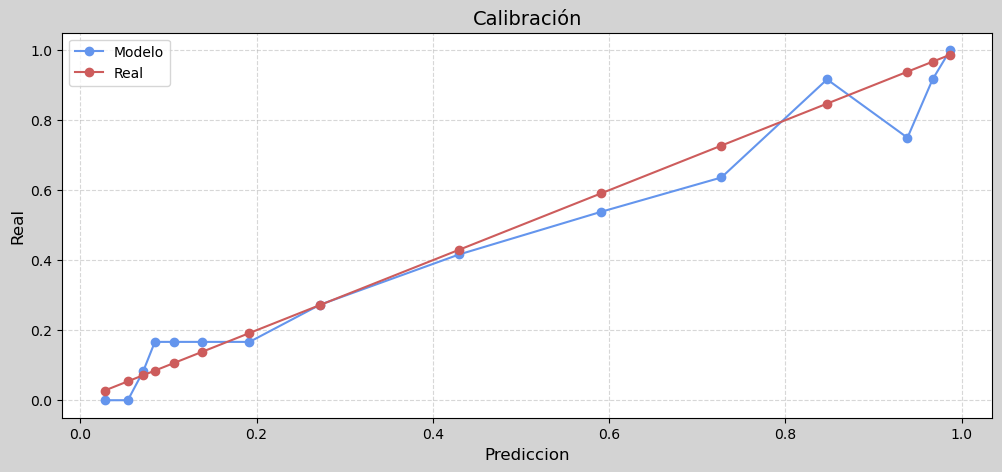

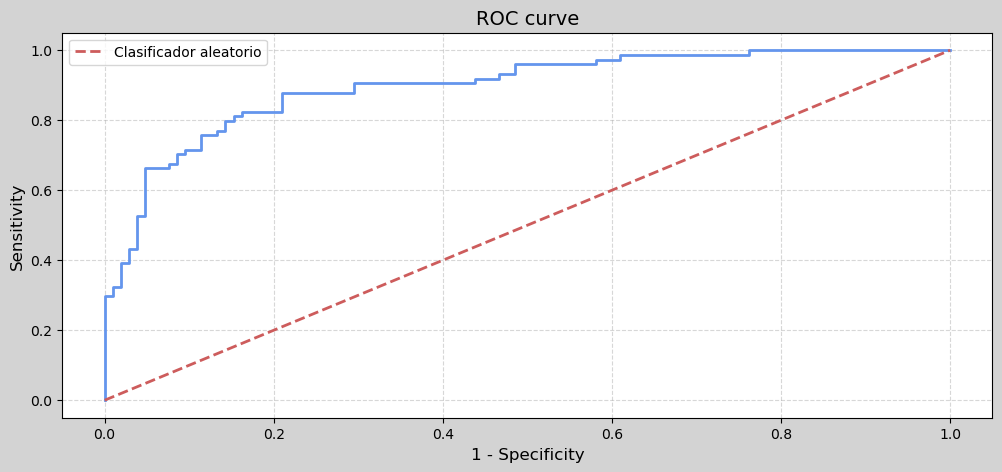

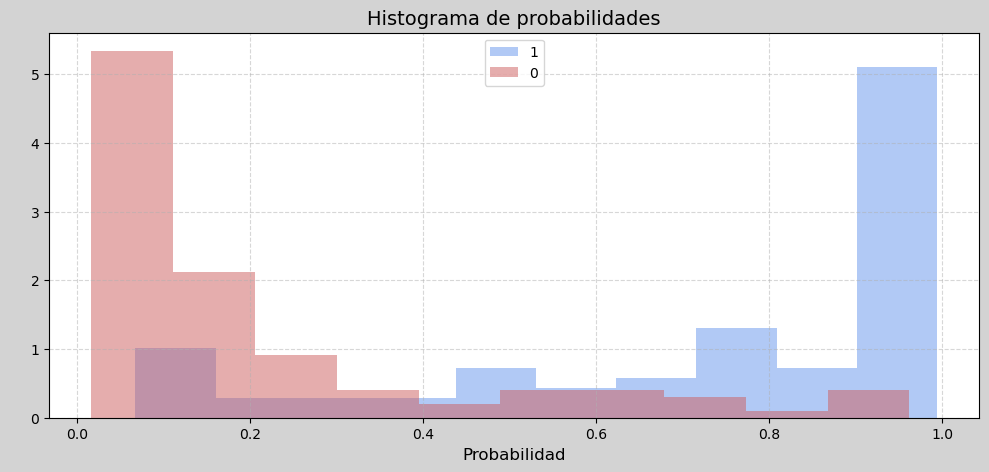

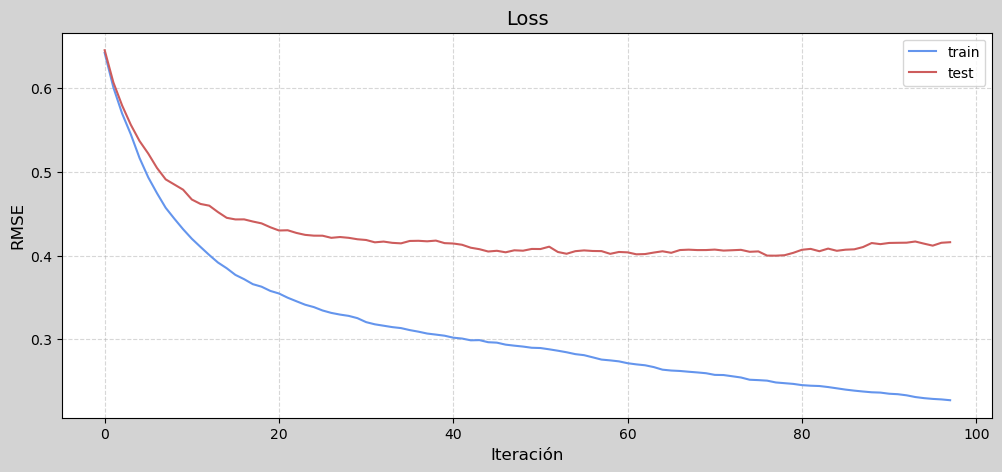

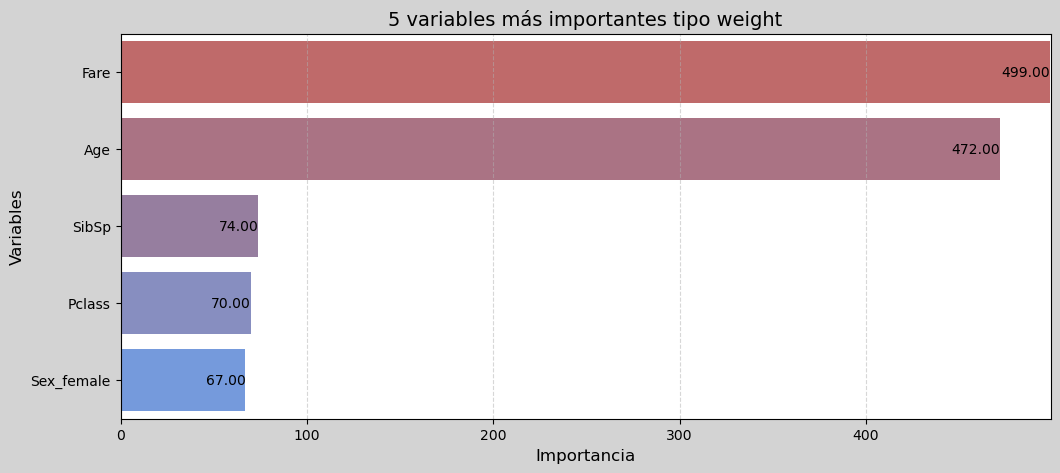

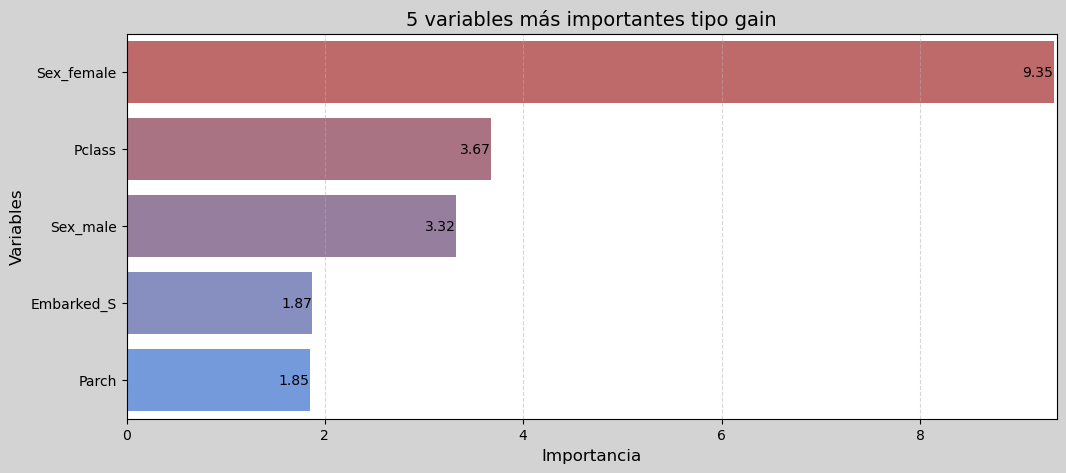

AUC: 0.8970
Gini: 0.7941


In [71]:
model = xgboost(X_train, X_test, y_train, y_test)

# Shap values

## Conjunto de prueba

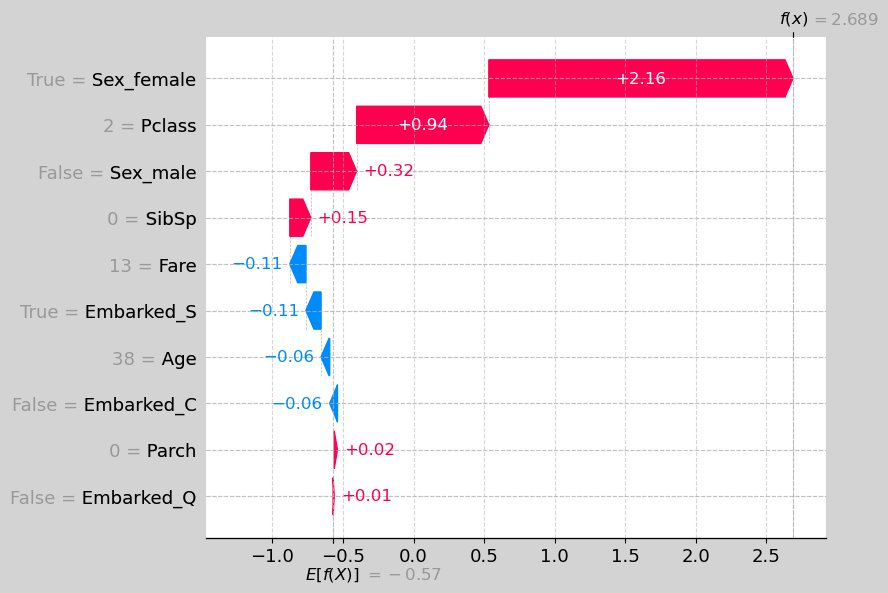

In [72]:
X_shap, shap_values = shap_prueba(X_test, model, 0, 10)

## Generales

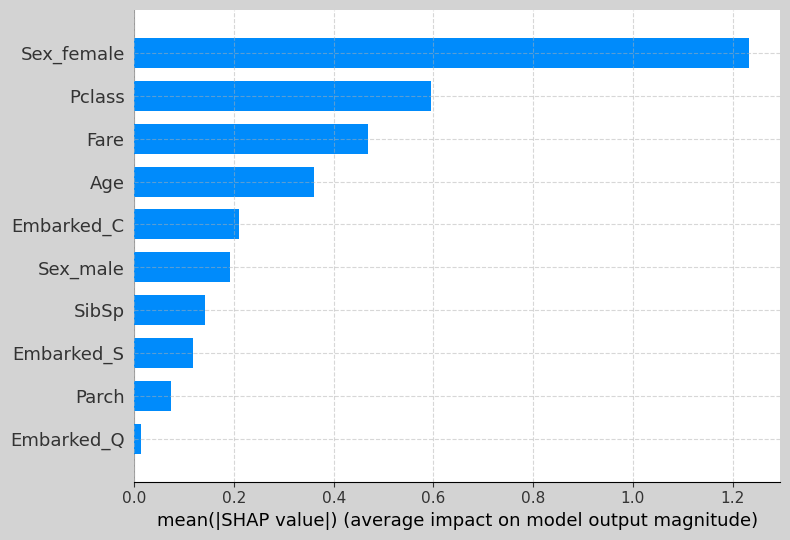

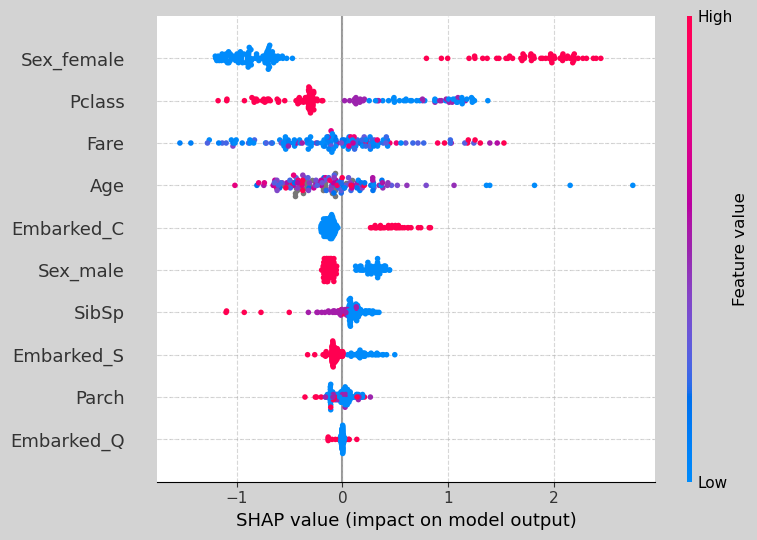

In [73]:
shap_plot(X_shap, shap_values, 10)

# KMeans

## Método del codo

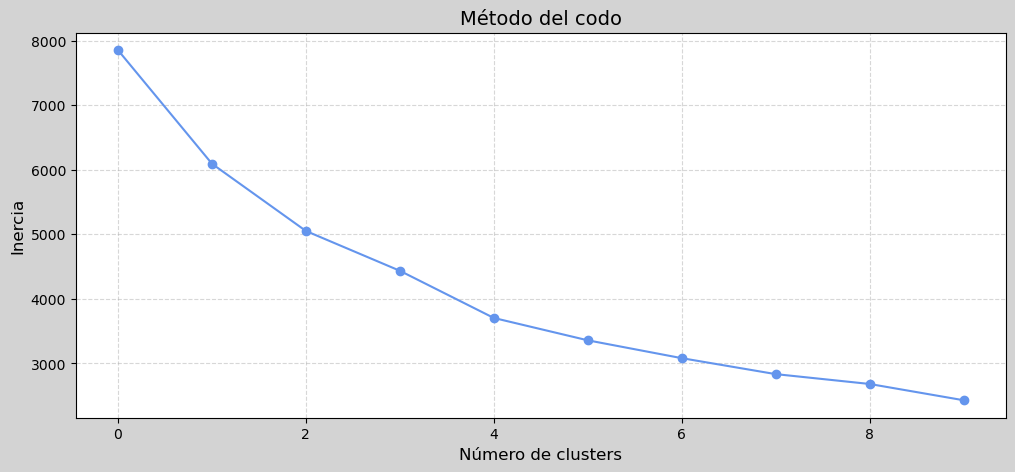

In [74]:
codo(data)

## Clusterización

In [76]:
data = clusters(data)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cluster
0,0,3,22.0,1,0,7.2500,False,True,False,False,True,1
1,1,1,38.0,1,0,71.2833,True,False,True,False,False,0
2,1,3,26.0,0,0,7.9250,True,False,False,False,True,2
3,1,1,35.0,1,0,53.1000,True,False,False,False,True,2
4,0,3,35.0,0,0,8.0500,False,True,False,False,True,1


## Análisis clusters

In [77]:
data.groupby('cluster').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,0.607692,1.746154,30.814769,0.423077,0.415385,68.296767,0.469231,0.530769,1.0,0.000000,0.000000
1,0.179688,2.424479,30.318359,0.463542,0.260417,21.745809,0.000000,1.000000,0.0,0.041667,0.958333
2,0.710000,2.195000,27.785000,0.665000,0.770000,37.714563,1.000000,0.000000,0.0,0.060000,0.930000


In [78]:
data.groupby('cluster').sum()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,79,227,4005.92,55,54,8878.5797,61,69,130,0,0
1,69,931,11642.25,178,100,8350.3907,0,384,0,16,368
2,142,439,5557.00,133,154,7542.9126,200,0,0,12,186
